# CLASIFICACIÓN DE PACIENTES CON INSUFICIENCIA CARDÍACA 

El objetivo de este análisis es predecir la supervivencia de los pacientes con insuficiencia cardíaca. El dataset de estudio se ha extraido de la plataforma Kaggle, el enlace es el siguinente: 

https://www.kaggle.com/datasets/aadarshvelu/heart-failure-prediction-clinical-records

Por otro lado, este dataset cita a un dataset menor de Heart Failure Clinical Records. (2020). UCI Machine Learning Repository.  El enlace:

https://doi.org/10.24432/C5Z89R.

# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,GridSearchCV,KFold, cross_val_score, cross_val_predict, ShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score

from sklearn.tree import plot_tree,export_text, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sns.set(style="whitegrid")

# LOAD DATA

In [2]:
file='heart_failure_clinical_records.csv'
df=pd.read_csv(file)
df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50,1


Información de variables:

- age: edad del paciente (años)
- anaemia: disminución de glóbulos rojos o hemoglobina (booleano)
- creatinine phosphokinase (CPK): nivel de la enzima CPK en la sangre (mcg/L)
- diabetes: si el paciente tiene diabetes (booleano)
- ejection fraction: porcentaje de sangre que sale del corazón en cada contracción (porcentaje)
- high blood pressure: si el paciente tiene hipertensión (booleano)
- platelets: plaquetas en la sangre (kiloplaquetas/mL)
- sex: mujer u hombre (binario)
- serum creatinine: nivel de creatinina sérica en la sangre (mg/dL)
- serum sodium: nivel de sodio sérico en la sangre (mEq/L)
- smoking: si el paciente fuma o no (booleano)
- time: período de seguimiento (días)
- DEATH_EVENT: si el paciente murió durante el período de seguimiento (booleano)

In [3]:
X=df.drop(['DEATH_EVENT'],axis=1)
y=df['DEATH_EVENT']

# EXPLORATORY DATA ANALYIST

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       5000 non-null   float64
 1   anaemia                   5000 non-null   int64  
 2   creatinine_phosphokinase  5000 non-null   int64  
 3   diabetes                  5000 non-null   int64  
 4   ejection_fraction         5000 non-null   int64  
 5   high_blood_pressure       5000 non-null   int64  
 6   platelets                 5000 non-null   float64
 7   serum_creatinine          5000 non-null   float64
 8   serum_sodium              5000 non-null   int64  
 9   sex                       5000 non-null   int64  
 10  smoking                   5000 non-null   int64  
 11  time                      5000 non-null   int64  
 12  DEATH_EVENT               5000 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 507.9 KB


Todas las variables del conjunto de datos se presentan como numéricas (int o float), pero sabemos que las variables 'anaemia', 'diabetes', 'high_blood_pressure', 'sex' y 'smoking' son variables binarias o booleanas. Por lo tanto, aplicaremos la transformación adecuada a estas variables para garantizar una correcta explicabilidad.

In [5]:
#Transformamos las variables indicadas a bool:
cols_transform = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
df[cols_transform] = df[cols_transform].astype(bool)

#Revisamos que se haya aplicado el cambio correctamente
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       5000 non-null   float64
 1   anaemia                   5000 non-null   bool   
 2   creatinine_phosphokinase  5000 non-null   int64  
 3   diabetes                  5000 non-null   bool   
 4   ejection_fraction         5000 non-null   int64  
 5   high_blood_pressure       5000 non-null   bool   
 6   platelets                 5000 non-null   float64
 7   serum_creatinine          5000 non-null   float64
 8   serum_sodium              5000 non-null   int64  
 9   sex                       5000 non-null   bool   
 10  smoking                   5000 non-null   bool   
 11  time                      5000 non-null   int64  
 12  DEATH_EVENT               5000 non-null   int64  
dtypes: bool(5), float64(3), int64(5)
memory usage: 337.0 KB


En este caso, todas las variables se consideran numéricas, incluidas las 5 mencionadas anteriormente, las cuales son booleanas. Para determinar si hay alguna otra variable numérica que pueda ser categorizada, aplicamos un conteo de los distintos valores de cada variable.

In [6]:
def conteo_valores(df):
    """
    Calcula la cantidad de valores distintos en cada columna de un DataFrame.
    
    Params:
        df (DataFrame): El DataFrame para el cual se calcularán los valores distintos.
        
    Return:
        DataFrame: con dos columnas: 'Variable' y 'Distintos' (cantidad de valores distintos).
    """
    # Calcular la cantidad de valores distintos en cada columna
    resultados = df.apply(lambda x: len(x.unique()))
        
    # Crear un DataFrame con los resultados
    resultado = pd.DataFrame({'Variable': resultados.index, 'Distintos': resultados.values})
    return resultado

# Llamamos a la función para realizar el conteo
conteo_valores(df)

,Variable,Distintos
0,age,48
1,anaemia,2
2,creatinine_phosphokinase,290
3,diabetes,2
4,ejection_fraction,17
5,high_blood_pressure,2
6,platelets,203
7,serum_creatinine,43
8,serum_sodium,27
9,sex,2


No se observan valores bajos en el conteo, excepto para las variables booleanas, lo que sugiere que puede no ser necesario aplicar una categorización a las variables numéricas.

A continuación, procedemos a observar la distribución de la variable objetivo para determinar si existe un desbalanceo en los datos. Además, revisamos las distribuciones de las variables booleanas para asegurar que estén representadas adecuadamente.

In [7]:
#Distribución variable objetivo DEATH_EVENT:
df['DEATH_EVENT'].value_counts()
df['DEATH_EVENT'].value_counts(normalize=True)

DEATH_EVENT
0    0.6864
1    0.3136
Name: proportion, dtype: float64

Estos resultados sugieren que hay un desbalance en la variable objetivo, ya que el valor 0 (sobrevivió) es mucho más frecuente que el valor 1 (falleció). Este desbalance puede afectar el rendimiento de los modelos por tanto deberemos tenerlo en cuenta.

In [8]:
#DISTRIBUCIÓN VARIABLES CATEGORICAS O BOOL:
categoricas=['anaemia','diabetes','high_blood_pressure','sex','smoking']

resultados={}
for categoria in categoricas:
    resumen = pd.DataFrame({
                'n': df[categoria].value_counts(),               # Conteo de frecuencias
                '%': df[categoria].value_counts(normalize=True)  # Porcentaje de frecuencias
                })
    resultados[categoria] = resumen

for clave in resultados:
    print(resultados[clave])
    print('---------------------')

            n       %
anaemia              
False    2628  0.5256
True     2372  0.4744
---------------------
             n       %
diabetes              
False     2803  0.5606
True      2197  0.4394
---------------------
                        n       %
high_blood_pressure              
False                3176  0.6352
True                 1824  0.3648
---------------------
          n       %
sex                
True   3228  0.6456
False  1772  0.3544
---------------------
            n       %
smoking              
False    3441  0.6882
True     1559  0.3118
---------------------


En este caso, es importante asegurarse de que ambas categorías estén bien representadas en el extracto de la muestra de estudio. Como se puede observar, existe una representación adecuada de ambas clases en cada una de las categorías, por tanto, no aplica nada.

## ATÍPICOS O OTULIERS

Por último se aplica un análisis de los outliers del conjunto del dataset

In [9]:
def atipicosAmissing(varaux):
    """
    Esta función identifica valores atípicos en una serie de datos y los reemplaza por NaN.
    
    Datos de entrada:
    - varaux: Serie de datos en la que se buscarán valores atípicos.
    
    Datos de salida:
    - Una nueva serie de datos con valores atípicos reemplazados por NaN.
    - El número de valores atípicos identificados.
    """

    # Verifica si la distribución de los datos es simétrica o asimétrica
    if abs(varaux.skew()) < 1:
        # Si es simétrica, calcula los valores atípicos basados en la desviación estándar
        criterio1 = abs((varaux - varaux.mean()) / varaux.std()) > 3
    else:
        # Si es asimétrica, calcula la Desviación Absoluta de la Mediana (MAD) y los valores atípicos
        mad = sm.robust.mad(varaux, axis=0)
        criterio1 = abs((varaux - varaux.median()) / mad) > 8
    
    # Calcula los cuartiles 1 (Q1) y 3 (Q3) para determinar el rango intercuartílico (H)
    qnt = varaux.quantile([0.25, 0.75]).dropna()
    Q1 = qnt.iloc[0]
    Q3 = qnt.iloc[1]
    H = 3 * (Q3 - Q1)
    
    # Identifica valores atípicos que están fuera del rango intercuartílico
    criterio2 = (varaux < (Q1 - H)) | (varaux > (Q3 + H))
    
    # Crea una copia de la serie original y reemplaza los valores atípicos por NaN
    var = varaux.copy()
    var[criterio1 & criterio2] = np.nan
    
    # Retorna la serie con valores atípicos reemplazados y el número de valores atípicos identificados
    return [var, sum(criterio1 & criterio2)]

In [10]:
# Definir las variables numéricas y categóricas para aplicar el pipeline (diferenciamos las bool)
numericas=['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
categoricas=['anaemia','diabetes','high_blood_pressure','sex','smoking']


#Cuento el porcentaje de atipicos de cada variable.La proporción de valores atípicos se calcula dividiendo la cantidad de valores atípicos 
#por el número total de filas
resultados = {x: atipicosAmissing(df[x])[1] / len(df) for x in numericas}
resultados

{'age': 0.0,
 'creatinine_phosphokinase': 0.0474,
 'ejection_fraction': 0.0,
 'platelets': 0.0032,
 'serum_creatinine': 0.0384,
 'serum_sodium': 0.0024,
 'time': 0.0}

Tras analizar los 5000 registros de pacientes para las variables numéricas, se observa que la presencia de datos atípicos u outliers es mínima. Dado que estos datos pertenecen al ámbito sanitario, es importante destacar que estos outliers  se van a tratar como desviaciones en los valores de las variables analizadas sobre el paciente, pero podria tratarse de errores en las mediciones. Sería beneficioso contrastar esta observación con la opinión de un especialista médico. En este contexto, no se realizarán cambios en los datos atípicos identificados.

## GRAFICOS DISTRIBUCIONES VARIABLES NUMÉRICAS

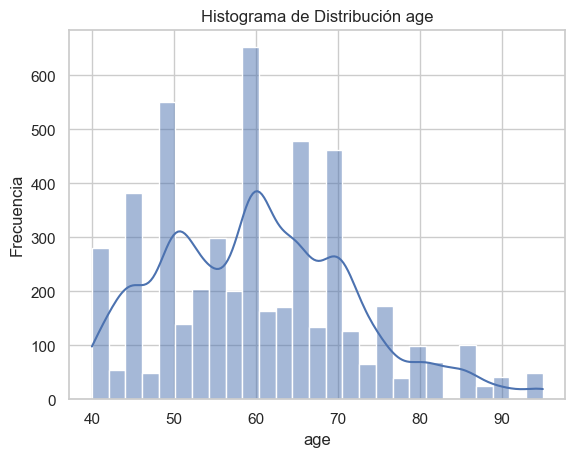

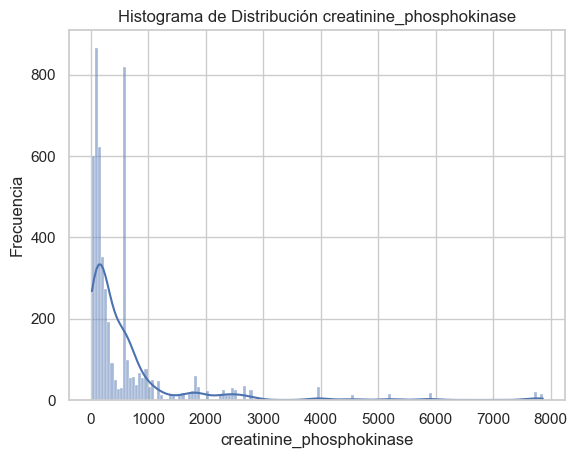

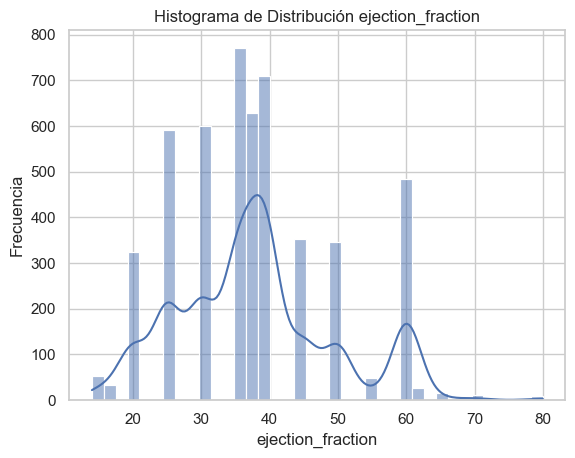

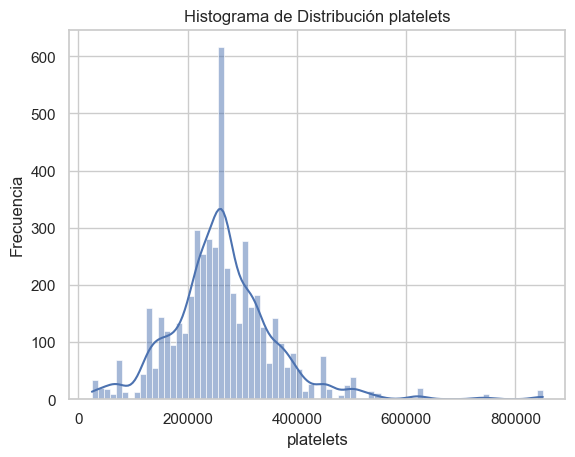

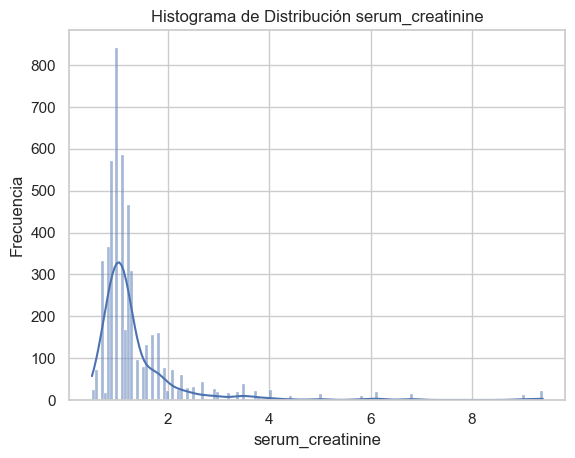

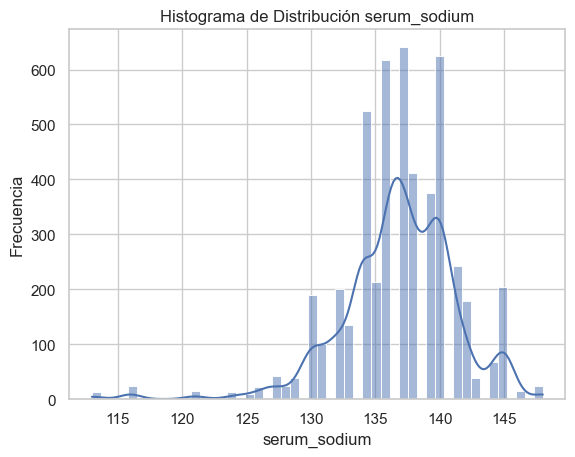

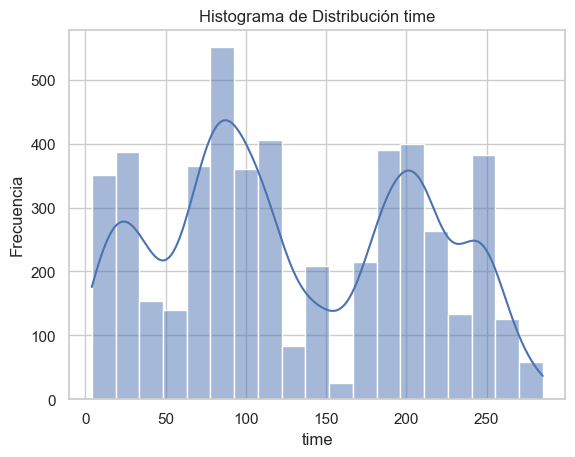

In [11]:
for variable in df[numericas]:   
    # Crear el histograma con la línea de tendencia
    sns.histplot(df[variable], kde=True)
    
    # Añadir título y etiquetas
    plt.title(f'Histograma de Distribución {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frecuencia')
    
    # Mostrar el histograma
    plt.show()

## GRAFICOS RELACIÓN ENTRE VARIABLES EXPLICATIVAS Y VARIABLE OBJETIVO

In [12]:
def mosaico_targetbinaria(var, target, nombre_eje):
    """
    Genera un gráfico de mosaico (mosaic plot) que muestra la relación entre una variable 'var' y una variable objetivo binaria 'target'.

    Parámetros:
    - var: Variable explicativa cualitativa.
    - target: Variable binario (0 o 1) que representa la variable objetivo.
    - nombre_eje: El nombre de la variable 'var' para etiquetar el eje x en el gráfico.

    Salida:
    - Muestra un gráfico de mosaico que representa la relación entre 'var' y 'target'.
    """

    # Crear un DataFrame que contiene 'var' y 'target'
    df = pd.DataFrame({nombre_eje: var, 'target': target})

    # Calcular una tabla de frecuencia cruzada y normalizarla por filas
    tabla_frecuencia = df.groupby([nombre_eje, 'target']).size().unstack(fill_value=0)
    tabla_frecuencia = tabla_frecuencia.div(tabla_frecuencia.sum(axis=1), axis=0)

    # Definir colores para las barras del gráfico
    colores = ['#FF6666', '#6699FF']

    # Crear un gráfico de barras apiladas (mosaic plot)
    ax = tabla_frecuencia.plot(kind='bar', stacked=True, color=colores)

    # Establecer etiquetas para los ejes x e y
    plt.xlabel(nombre_eje)  # Eje x representa 'var'
    plt.ylabel('Frecuencia Target')  # Eje y representa la frecuencia de 'target'
    plt.figure(figsize=(15, 10))

    # Rotar las etiquetas del eje x para mejorar la legibilidad
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Mostrar el gráfico de mosaico
    plt.show()

En los siguientes gráficos, se puede observar que las variables binarias no ofrecen mucha información sobre la variable objetivo, ya que no se aprecia una diferencia marcada entre sus clases. Por lo tanto, estas variables no contribuirán significativamente a la clasificación de DEATH_EVENTS.

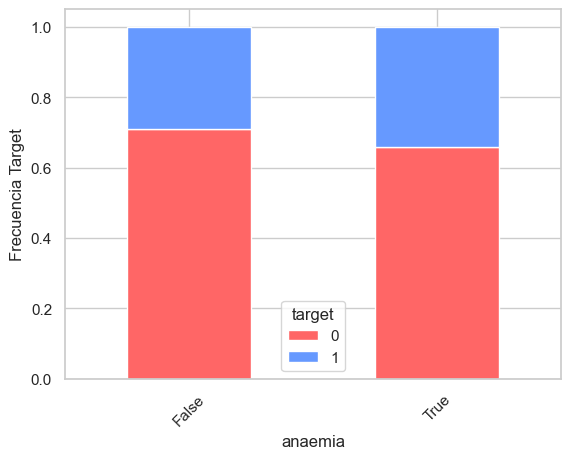

<Figure size 1500x1000 with 0 Axes>

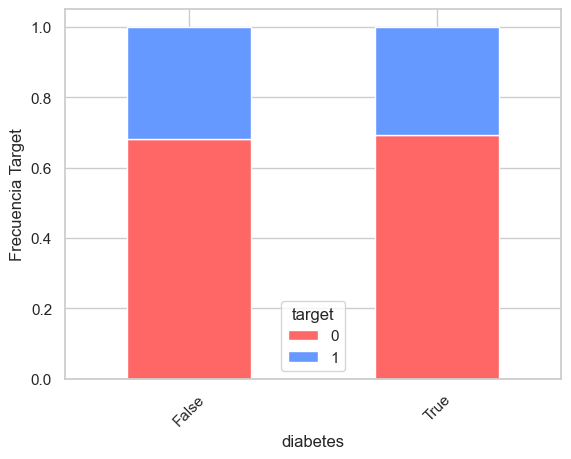

<Figure size 1500x1000 with 0 Axes>

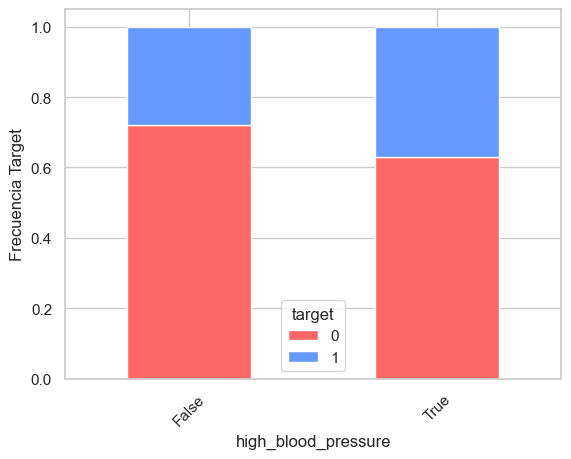

<Figure size 1500x1000 with 0 Axes>

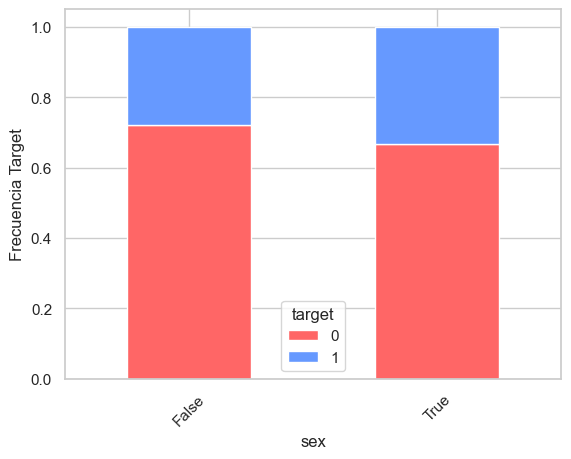

<Figure size 1500x1000 with 0 Axes>

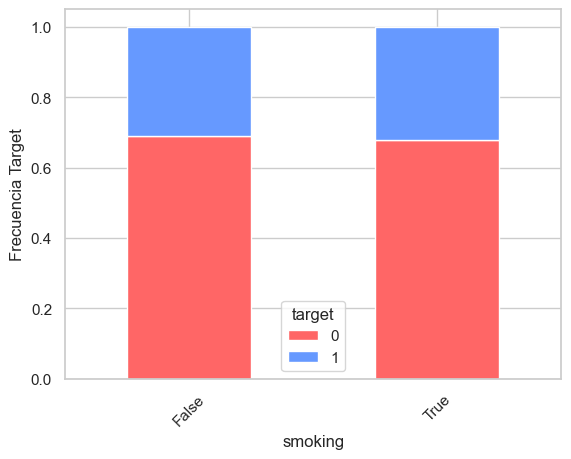

<Figure size 1500x1000 with 0 Axes>

In [13]:
#Representación variables binarias en relación a la variable objetivo
for variable in categoricas:
    mosaico_targetbinaria(df[variable], df['DEATH_EVENT'], variable)

In [14]:
def boxplot_targetbinaria(var, target, nombre_eje):
    """
    Genera un boxplot para una variable 'var' en función de una variable objetivo binaria 'target'.

    Parámetros:
    - var: Variable explicativa continua.
    - target: Variable binario (0 o 1) que representa la variable objetivo.
    - nombre_eje: El nombre del eje y (etiqueta) en el gráfico.

    Salida:
    - Muestra un gráfico de caja ('boxplot') que compara la variable 'var' para cada valor de 'target'.
    """

    # Crear una figura para el gráfico con un tamaño de 8x6 pulgadas
    plt.figure(figsize=(8, 6))

    # Crear un boxplot donde 'x' representa los valores de 'target' y 'y' representa 'var'
    sns.boxplot(x=target, y=var)

    # Establecer etiquetas para los ejes x e y
    plt.xlabel('target')  # Eje x representa 'target'
    plt.ylabel(nombre_eje)  # Eje y representa 'var'

    # Mostrar el gráfico
    plt.show()   

Por el contrario, en las variables numéricas sí podemos destacar diferencias significativas entre las clases. Específicamente, podemos resaltar lo siguiente:

- ejection_fraction: Observamos que los pacientes que sobreviven tienden a presentar valores más elevados en esta variable, la cual indica el porcentaje de sangre que bombea el corazón.

- time: También es evidente que un seguimiento más prolongado del paciente se correlaciona con una mayor supervivencia.

- serum_sodium: niveles más altos de sodio en suero están asociados con una mayor supervivencia.

- serum_creatinine: en este caso, niveles más bajos de creatinina en suero están relacionados con una mayor supervivencia en los pacientes.

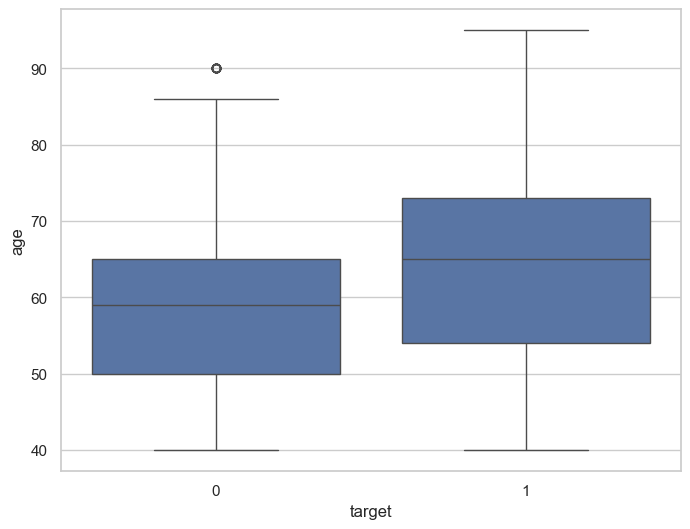

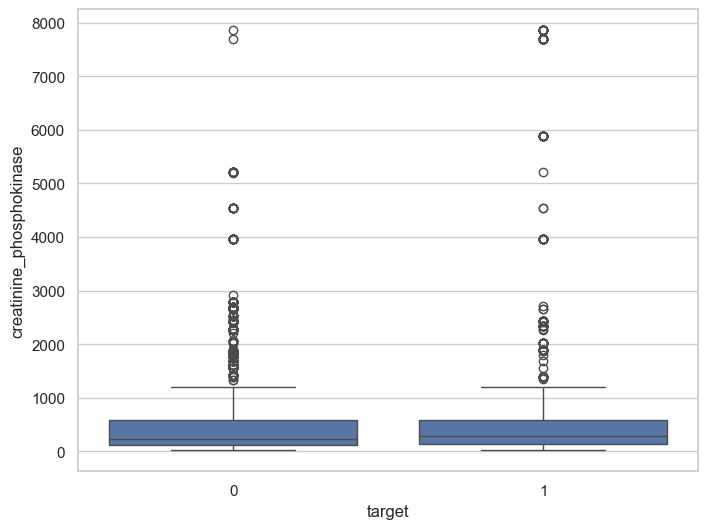

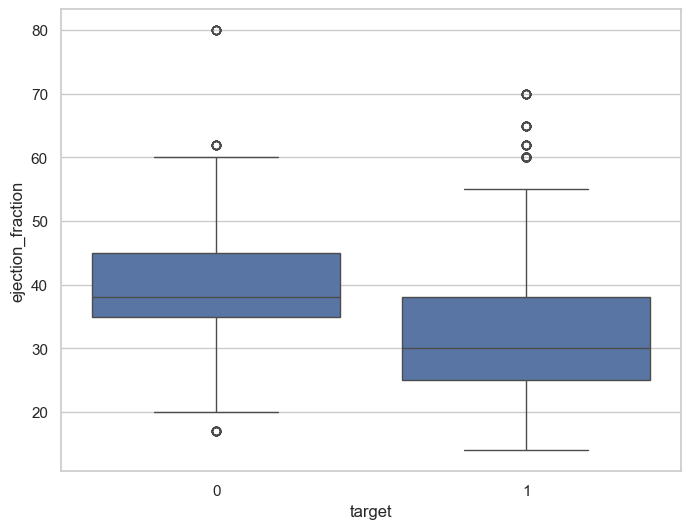

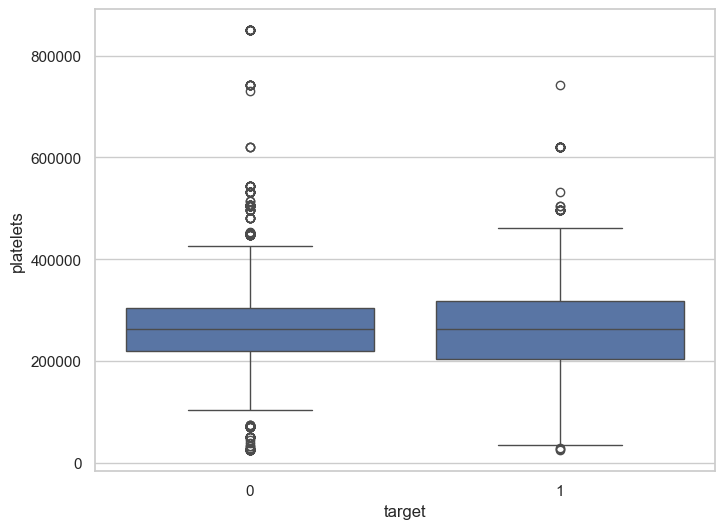

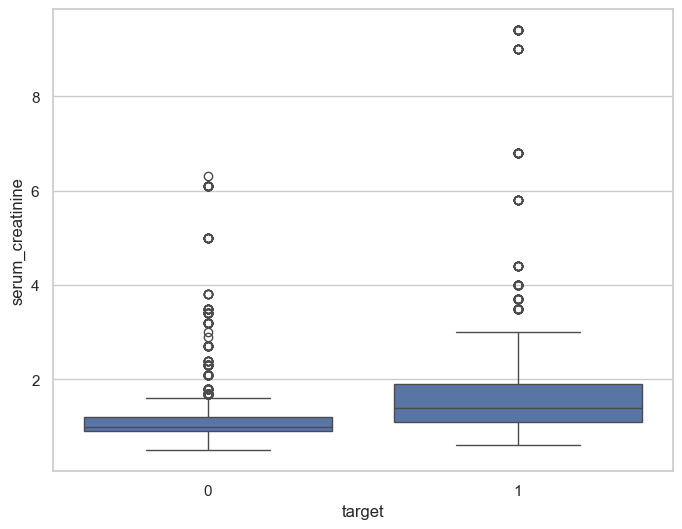

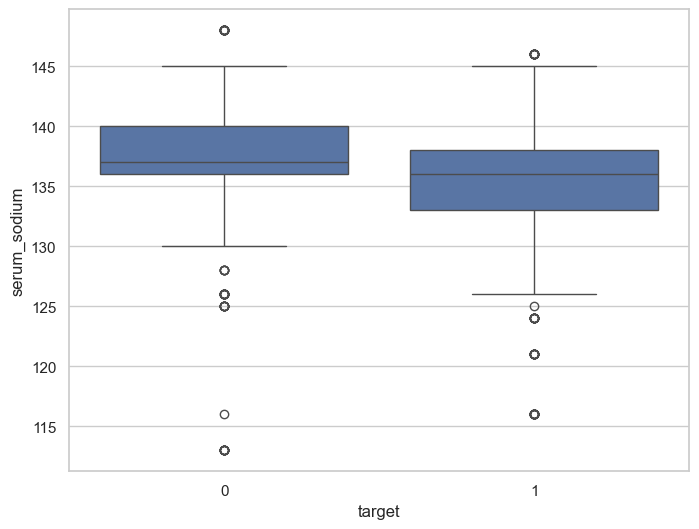

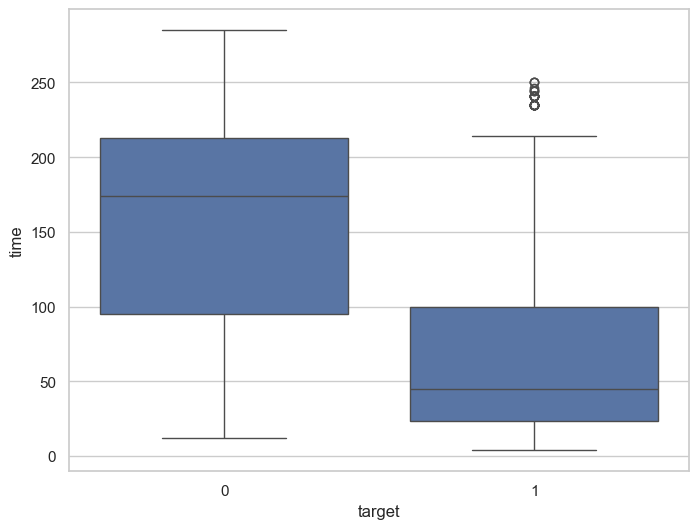

In [15]:
#Representación variables numérica en relación a la variable objetivo
for variable in numericas:
    boxplot_targetbinaria(df[variable], df['DEATH_EVENT'], variable)

## IMPORTANCIAS VARIABLES

Dado lo observado en los gráficos anteriores, sería interesante realizar un análisis de la importancia de las variables explicativas sobre la variable objetivo. Para ello, se aplicará un árbol de decisión.

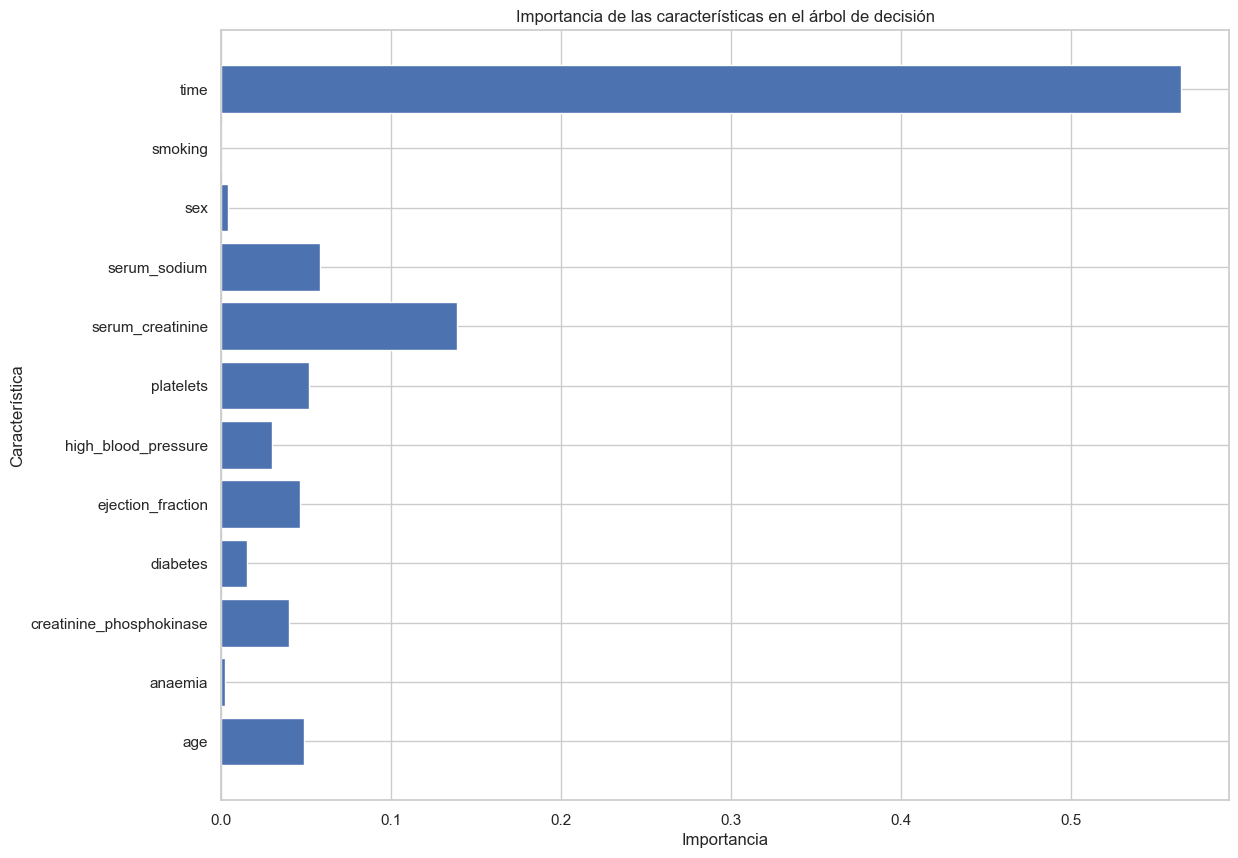

In [16]:
#Definir la semilla
seed=123

# Crear la instancia del árbol y entrenarlo con todo el dataset
arbol = DecisionTreeClassifier(random_state=seed)
arbol.fit(X,y) 

# Extraer los valores de importancia de las características
pd.DataFrame(zip(arbol.feature_importances_, X.columns), columns=['importance', 'feature']).\
             sort_values('importance', ascending=True)


# Definir el gráfico de barras
plt.figure(figsize=(13, 10))
plt.barh(y=X.columns, width=arbol.feature_importances_)
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características en el árbol de decisión')
plt.show()

Observamos claramente que las variables binarias, como 'smoking', 'sex' y 'anaemia', tienen una importancia muy baja, lo que respalda lo observado en los gráficos anteriores. Por otro lado, destacamos la importancia de la variable 'time' para el modelo de árbol. En este caso, sería interesante considerar la eliminación de esta variable, ya que no siempre es factible tener un seguimiento exhaustivo de los pacientes y no está directamente relacionada con una variable fisiológica del individuo, lo que simplificaría los procesos de predicción en un momento temprano.

# TRAIN-TEST

In [17]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=seed)

# SELECCIÓN DEL MODELO

Para la selección del modelo se van a presentar 7 modelados distintos que funcionan bien para clasifiación, no se van a incluir modelos muy complejos dado que al tratarse del ámbito sanitario es importante tener una buena explicabilidad de los modelos.

In [18]:
#Definimos todos los modelos y los almacenamos en una variable 
models=[]
models.append(('LR',LogisticRegression(random_state=seed)))
models.append(('DTC',DecisionTreeClassifier(random_state=seed)))
models.append(('NB',GaussianNB()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('RFC',RandomForestClassifier(random_state=seed)))
models.append(('SVM',SVC()))


def boxplots_algorithms(results, names):
    plt.figure(figsize=(8,4))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

Matriz de confusión para LR en train:
 [[2509  248]
 [ 378  865]]
Matriz de confusión para LR en test:
 [[619  56]
 [107 218]]
-------------------------------------------------------
Matriz de confusión para DTC en train:
 [[2738   19]
 [  30 1213]]
Matriz de confusión para DTC en test:
 [[668   7]
 [  7 318]]
-------------------------------------------------------
Matriz de confusión para NB en train:
 [[2557  200]
 [ 639  604]]
Matriz de confusión para NB en test:
 [[625  50]
 [175 150]]
-------------------------------------------------------
Matriz de confusión para KNN en train:
 [[2740   17]
 [  51 1192]]
Matriz de confusión para KNN en test:
 [[668   7]
 [ 11 314]]
-------------------------------------------------------
Matriz de confusión para LDA en train:
 [[2515  242]
 [ 383  860]]
Matriz de confusión para LDA en test:
 [[623  52]
 [107 218]]
-------------------------------------------------------
Matriz de confusión para RFC en train:
 [[2753    4]
 [  25 1218]]
Matriz de co

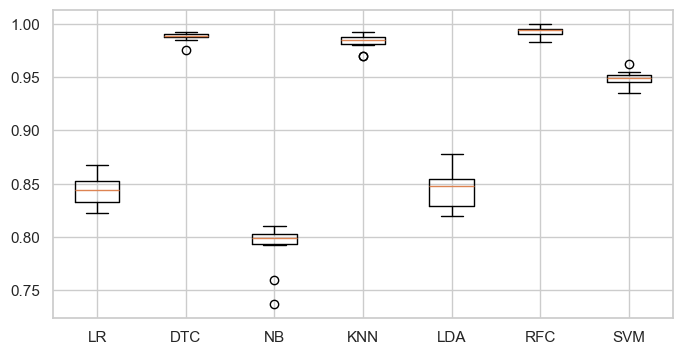

In [19]:
results = []
names = []


numericas=['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
categoricas=['anaemia','diabetes','high_blood_pressure','sex','smoking']

# Definir la transformación de las variables
col_transformer=ColumnTransformer([
    ('std',StandardScaler(),numericas), 
    ('ohe1',OneHotEncoder(drop='if_binary'),categoricas)],
    remainder='passthrough')

# Bucle para cada modelo
for name, model in models:
    model_pipeline=Pipeline([
            ('transformacion',col_transformer),
            ('modelo',model)
    ])

    # Realizar validación cruzada
    cv_technique=KFold(n_splits=10, shuffle=True,random_state=seed)
    cv_result=cross_val_score(model_pipeline,x_train,y_train,cv=cv_technique,scoring='accuracy')
    
    # Guardar los resultados de la validación cruzada
    names.append(name)
    results.append(cv_result)

    # Predecir y calcular la matriz de confusión para train
    y_pred = cross_val_predict(model_pipeline, x_train, y_train, cv=cv_technique)
    cm = confusion_matrix(y_true=y_train, y_pred=y_pred)  # Calcula la matriz de confusión
    print(f"Matriz de confusión para {name} en train:\n {cm}")
    
    # Entrenar el modelo con el conjunto de entrenamiento
    model_pipeline.fit(x_train, y_train)
    # Predecir y calcular la matriz de confusión para test
    y_pred_test = model_pipeline.predict(x_test)
    cm_test = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
    print(f"Matriz de confusión para {name} en test:\n {cm_test}")
    print('-------------------------------------------------------')

#Generar un diagrama de caja y bigotes con los resultados de la validación cruzada llamando a la función boxplots_algorithms
boxplots_algorithms(results, names)

Dado que se trata de una predicción en el ámbito clínico, es crucial aplicar más de una métrica de evaluación para seleccionar inicialmente los mejores modelos. Además, debido a la naturaleza clínica del problema, la explicabilidad del modelo es fundamental para una correcta interpretación en el ámbito sanitario.

Al observar el gráfico anterior de la métrica accuracy, se destaca que los modelos de árboles, específicamente el Decision Tree Classifier y el Random Forest, tienen el mejor rendimiento, incluido si nos fijamos en la matriz de confusión. Estos modelos también muestran la menor variabilidad en los resultados y ofrecen una mayor interpretabilidad. Siguiendo el principio de parsimonia, es prudente optar por un modelo más simple como el Decision Tree Classifier, ya que permite trabajar con un solo árbol y facilita su interpretación.

# EVALUACIÓN 

Con el modelo DecisionTreeClassifier seleccionado, se procede a evaluar nuevamente el modelo individualmente, esta vez aportando las métricas de precisión (precision) y exhaustividad (recall).

Remarcar que nuestro análisis busca precedir la supervivencia de pacientes con insuficiencia cardíaca (0 sobrevive,1 muere), por tanto buscamos precedir correctamente cuando no hay muerte o cuando DEATH_EVENT=0. Por tanto, nuestro objetivo es reducir al máximo los falsos positivo, es decir, un paciente que no muere y el modelo lo clasifica como que muere, porque deseamos controlar la superviencia de los pacientes. Para evaluar el rendimiento del modelo, nos enfocaremos en la precisión, que indica la proporción de predicciones positivas correctas en relación con todas las predicciones positivas realizadas por el modelo. Una precisión alta implica que el modelo identifica correctamente la mayoría de los casos positivos, lo que se traduce en una baja tasa de falsos negativos.

In [20]:
model=DecisionTreeClassifier(random_state=seed)

model_pipeline=Pipeline([
            ('transformacion',col_transformer),
            ('modelo',model)
    ])
model_pipeline.fit(x_train,y_train)

# Predecir y calcular métricas en test
y_pred=model_pipeline.predict(x_test)

acc_test=accuracy_score(y_true=y_test,y_pred=y_pred)
cm_test=confusion_matrix(y_true=y_test,y_pred=y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)


# Predecir y calcular métricas en train
y_pred_train=model_pipeline.predict(x_train)

acc_train=accuracy_score(y_true=y_train,y_pred=y_pred_train)
cm_train=confusion_matrix(y_true=y_train,y_pred=y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)

# Crear una tabla para mostrar los resultados
results_df = pd.DataFrame({
    'Conjunto datos': ['Entrenamiento', 'Prueba'],
    'Precisión': [precision_train, precision_test],
    'Sensibilidad': [recall_train, recall_test],
    'Exactitud': [acc_train, acc_test],
    'Matriz de Confusión': [cm_train, cm_test]
})

# Mostrar los resultados en una tabla
results_df.round(2)

,Conjunto datos,Precisión,Sensibilidad,Exactitud,Matriz de Confusión
0,Entrenamiento,1.00,1.00,1.00,"[[2757, 0], [2, 1241]]"
1,Prueba,0.98,0.98,0.99,"[[668, 7], [7, 318]]"


In [21]:
#Revisión parámetros modelos
modelo_params=model_pipeline.named_steps['modelo'].get_params()
modelo_params

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 123,
 'splitter': 'best'}

En este análisis, todas las métricas muestran valores muy buenos, en concreto la precisión, alcanza el 99%. Por lo tanto, podemos concluir que este modelo es adecuado para aplicar la predicción deseada.

Este modelo sin aplicar un fine tuning ya nos está ofreciendo resultados muy buenos, y podemos observar que no hay una diferencia significativa entre las métricas de entrenamiento y prueba, lo que sugiere que no hay sobreajuste y el modelo generaliza bien. Sin embargo, para intentar mejorar aún más el rendimiento del modelo y reducir cualquier posible diferencia entre el conjunto de prueba y el de entrenamiento, realizaremos un ajuste fino mediante la aplicación de una poda controlada.

# FINE TUNING 

Para acabar de ajustar el modelo aplicaremos un fine tuning. Para impedir que el árbol se ajuste demasiado a los datos de entrenamiento, atacaremos sobre los hiperparámetros:
- max_depth: para definir una serie de profundidades del árbol máximas.
- min_samples_split: número minimo de muestras que debe tener un nodo para poder dividirse.
- min_samples_leaf: número mínimo de muestras que debe tener un nodo terminal. 


Dado que anteriormente se ha observado un buen resultado del modelo sin ajustar, y el parámetro max_depth se habia definido como predeterminado en None, aplicaremos un análisis con el modelo con sus parámetros predeterminados pero observando su comportamiento sobre el max_depth respecto a la métrica accuracy. 

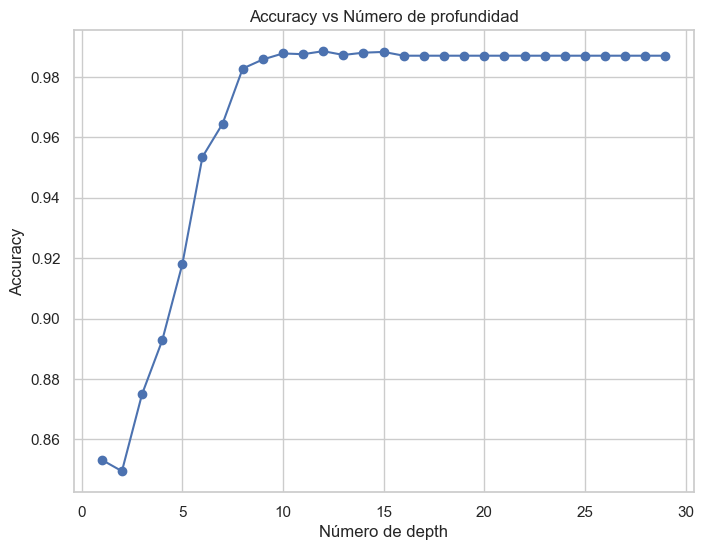

In [22]:

# Definir el rango de valores para max_depth que queremos explorar
est_range = range(1, 30)
# Definimos parámetros del cross-validation
n_reps = 5  
folds = 4

n_est_dict = {}
# Iterar sobre los diferentes valores de max_depth
for dept in est_range:
    scores = []
    # Realizar varias repeticiones de validación cruzada para cada valor de max_depth
    for rep in range(n_reps):
        arbol = DecisionTreeClassifier(random_state=seed,max_depth=dept)
        scores_arbol = cross_val_score(arbol, x_train, y_train, cv=folds, scoring='accuracy')
        scores.append(scores_arbol.mean())
    # Calcular el promedio accuracy para todas las repeticiones
    n_est_dict[dept] = np.array(scores).mean()

# Ordenar los resultados por el número de depth
res_list = sorted(n_est_dict.items())  
depths, accs = zip(*res_list)  

# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.plot(depths, accs, marker='o', linestyle='-')
plt.xlabel("Número de depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Número de profundidad")
plt.grid(True)
plt.show()

En el gráfico anterior, podemos observar claramente que a partir de max_depth=9, el modelo no mejora en precisión (accuracy). Este valor será el límite máximo que estableceremos en la definición de este parámetro en la rejilla del grid search.

Por otro lado, en el modelo predeterminado, los parámetros min_samples_split y min_samples_leaf se establecen en 2 y 1 respectivamente. Valores bajos en estos parámetros permiten una mayor división del árbol, lo que conduce a árboles más profundos y complejos. En este caso, estableceremos el mínimo en 3 para ambos parámetros y observaremos su comportamiento.

In [23]:
alg=DecisionTreeClassifier(random_state=seed)

model_pipeline=Pipeline([
            ('transformacion',col_transformer),
            ('alg',alg)
    ])

model_pipeline.fit(x_train,y_train)

cv_technique=KFold(n_splits=5,shuffle=True,random_state=seed)

# Definir los parámetros para el grid search
parametros = {
    'alg__criterion': ['gini','entropy'], 
    'alg__max_depth': [3,5,9],
    'alg__min_samples_split':[3,7,10],
    'alg__min_samples_leaf':[3,7,10]
}

grid_model=GridSearchCV(model_pipeline,cv=cv_technique,scoring='accuracy',param_grid=parametros)
grid_model.fit(x_train,y_train)

# Predecir y calcular métricas para test
y_pred=grid_model.predict(x_test)
acc_test=accuracy_score(y_true=y_test,y_pred=y_pred)
cm_test=confusion_matrix(y_true=y_test,y_pred=y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)

# Predecir y calcular métricas para train
y_pred_train=grid_model.predict(x_train)
acc_train=accuracy_score(y_true=y_train,y_pred=y_pred_train)
cm_train=confusion_matrix(y_true=y_train,y_pred=y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)

# Crear una tabla para mostrar los resultados
results_df = pd.DataFrame({
    'Conjunto datos': ['Entrenamiento', 'Prueba'],
    'Precisión': [precision_train, precision_test],
    'Sensibilidad': [recall_train, recall_test],
    'Exactitud': [acc_train, acc_test],
    'Matriz de Confusión': [cm_train, cm_test]
})


# Imprimir la mejor puntuación obtenida por el modelo grid search
print(f'Best score accuracy o exactitud: {grid_model.best_score_:.4f}')

# Mostrar los resultados en una tabla
results_df.round(2)

Best score accuracy o exactitud: 0.9858


,Conjunto datos,Precisión,Sensibilidad,Exactitud,Matriz de Confusión
0,Entrenamiento,0.98,0.99,0.99,"[[2727, 30], [18, 1225]]"
1,Prueba,0.96,0.98,0.98,"[[663, 12], [7, 318]]"


In [24]:
#Mostramos el mejor modelo seleccionado por grid search
grid_model.best_estimator_

Pipeline(steps=[('transformacion',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', StandardScaler(),
                                                  ['age',
                                                   'creatinine_phosphokinase',
                                                   'ejection_fraction',
                                                   'platelets',
                                                   'serum_creatinine',
                                                   'serum_sodium', 'time']),
                                                 ('ohe1',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['anaemia', 'diabetes',
                                                   'high_blood_pressure', 'sex',
                                                   'smoking'])])),
                ('alg',
                 DecisionTreeClassifier(criterion='entropy', max_depth=9,
                                        min_samples_leaf=3,
                                        min_samples_split=10,
                                        random_state=123))])

Si nos fijamos en los parámetros resultantes del grid search, observamos como para max_depth el modelo opta por establecer el valor máximo y aquí sabemos que valores más grandes no nos ofrece una mejora y tiende a producir sobreajuste, por tanto, lo aceptaremos. 

Por contra los min_samples de leaf y split tienden a ir al mínimo valor de la rejilla. Si se observan los resultados del test el modelo ha empeorado mínimamente, reduciendo un 1% en precision y por tanto se observa también en la matriz de confusión un mínimo aumento de los FP y los FN, en concreto queriamos reducir al máximo los FP, y el cambio pasa de 4 a 5. En éste caso, optar por bajar estos valores nos ofrecerá un árbol más profundo aunque ya los valores de ambos parámetros son muy bajos la diferencia seria mínima, por tanto, decantaremos por el modelo con los parámetros por defecto.

# CONCLUSIONES

Basándonos en el análisis realizado, podemos concluir que utilizando un modelo DecisionTreeClassifier con sus valores predeterminados, sin necesidad de fine tuning, obtenemos un buen modelo para predecir la supervivencia de pacientes con insuficiencia cardíaca. En particular, hemos logrado métricas superiores al 98%, con una precisión del 99%, lo que nos ayuda a reducir los falsos positivos.

Como parte del cierre del análisis, y considerando que se trata de una predicción para el ámbito sanitario donde la explicabilidad es crucial, hemos generado una visualización del árbol resultante del modelo final. Es importante tener en cuenta que al establecer un max_depth en 10 y valores bajos para min_samples, el árbol resultante será bastante profundo, lo que puede dificultar su visualización gráfica. Por este motivo, se acompaña con otra visualización en formato texto.

Destacar también que el desbalanceo en la distribución de clases de la variable objetivo puede afectar los resultados del modelo, especialmente en la capacidad para predecir con precisión la clase minoritaria, en este caso la muerte (1). Esto puede provocar un sesgo hacia la clase mayoritaria, lo que significa que el modelo puede tener dificultades para aprender patrones en la clase minoritaria debido a la falta de ejemplos de esa clase. Como resultado, es posible que la precisión de la predicción para la clase minoritaria sea más baja en comparación con la clase mayoritaria.

En nuestro caso, el objetivo es predecir la clase mayoritaria, y es posible que el desbalanceo en la distribución de clases tenga menos impacto en la capacidad del modelo para predecir esta clase. Sin embargo, es importante considerar que el desbalanceo puede afectar la capacidad del modelo para generalizar y puede conducir a resultados sesgados.

Por lo tanto, incluso cuando el objetivo es predecir la clase mayoritaria, es recomendable abordar el desbalanceo de clases para garantizar que el modelo sea robusto y tenga una capacidad predictiva sólida. Esto ayudará a mejorar la calidad general del modelo y evitar posibles sesgos que podrían surgir debido al desbalanceo de clases.

Además, se identifican algunas posibles acciones de mejora:

- Realizar un balanceo de la variable objetivo. 
- Realizar un análisis de componentes principales (PCA) para reducir la dimensionalidad de los datos.
- Realizar un análisis de importancia de características y eliminar variables que no tienen una gran relevancia sobre la variable objetivo.
- Evaluar el efecto de eliminar la variable 'time' en el modelo.

## ARBOL SELECCIONADO

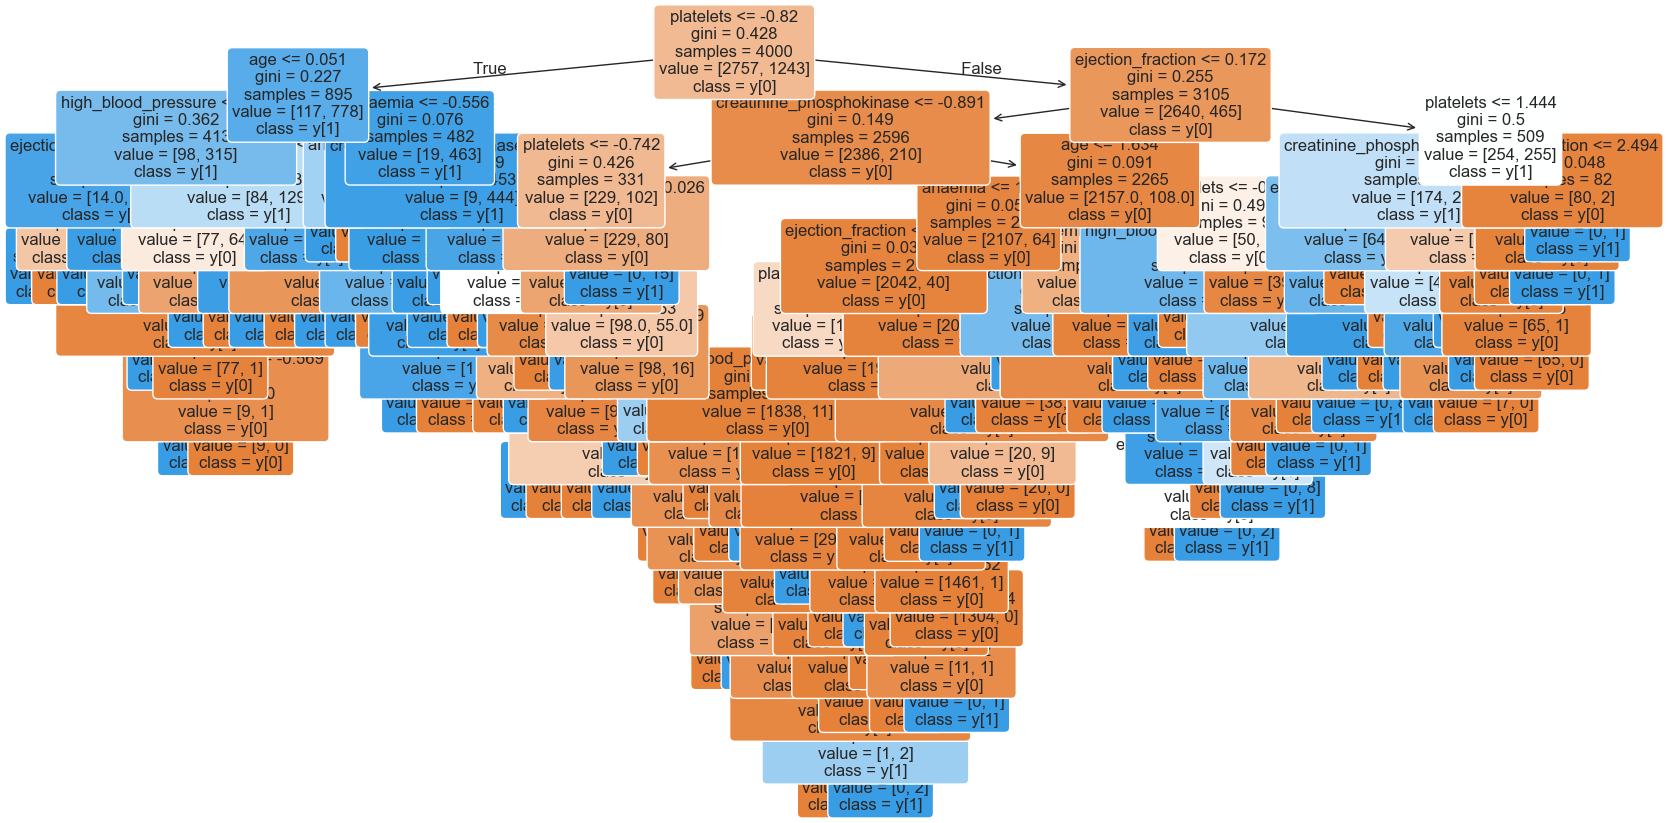

In [25]:
modelo_final= model

# Visualizar el árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(modelo_final, 
          feature_names=X.columns,
          class_names=True, 
          filled=True, 
          rounded=True,
          fontsize=12)
plt.show()

In [26]:
# Obtener información detallada de cada nodo y las reglas de decisión
tree_rules = export_text(model, feature_names=list(x_train.columns),show_weights=True)
print(tree_rules)

|--- platelets <= -0.82
|   |--- age <= 0.05
|   |   |--- high_blood_pressure <= -0.07
|   |   |   |--- ejection_fraction <= -0.52
|   |   |   |   |--- age <= -0.98
|   |   |   |   |   |--- weights: [0.00, 6.00] class: 1
|   |   |   |   |--- age >  -0.98
|   |   |   |   |   |--- weights: [11.00, 0.00] class: 0
|   |   |   |--- ejection_fraction >  -0.52
|   |   |   |   |--- anaemia <= 1.67
|   |   |   |   |   |--- weights: [0.00, 170.00] class: 1
|   |   |   |   |--- anaemia >  1.67
|   |   |   |   |   |--- anaemia <= 5.10
|   |   |   |   |   |   |--- weights: [3.00, 0.00] class: 0
|   |   |   |   |   |--- anaemia >  5.10
|   |   |   |   |   |   |--- weights: [0.00, 10.00] class: 1
|   |   |--- high_blood_pressure >  -0.07
|   |   |   |--- high_blood_pressure <= 0.38
|   |   |   |   |--- platelets <= -1.54
|   |   |   |   |   |--- weights: [0.00, 43.00] class: 1
|   |   |   |   |--- platelets >  -1.54
|   |   |   |   |   |--- diabetes <= 1.80
|   |   |   |   |   |   |--- creatinine_pho